<a href="https://colab.research.google.com/github/couyang24/general_learning-tiffany/blob/master/colab_titanic_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Need to mount Drive on or upload kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
!cp drive/My\ Drive/input/kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install shap

In [ ]:
# Load Package
import numpy as np
import pandas as pd
import seaborn as sns
import featuretools
import shap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import featuretools as ft

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    LabelEncoder,
    OrdinalEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [ ]:
# Load data
train_df= pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
# Save data
target = train_df[["Survived"]]
submission = test_df[["PassengerId"]]

In [ ]:
# Join and Clean
combine = pd.concat([train_df, test_df])

In [ ]:
# EDA
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [ ]:
combine.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

In [ ]:
combine['Title'] = combine.Name.apply(lambda x: x.split(".")[0].split(",")[1].strip()).replace(mapping)

In [ ]:
# combine['Sex2'] = combine['Sex'].apply(lambda x: 0 if x=='female' else 1)

In [ ]:
# class ModifiedLabelEncoder(LabelEncoder):

#     def fit_transform(self, y, *args, **kwargs):
#         return super().fit_transform(y)

#     def transform(self, y, *args, **kwargs):
#         return super().transform(y)

In [ ]:
miss_ind = Pipeline(steps=[
    ('indicator', MissingIndicator(error_on_new=False)),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encode", OrdinalEncoder()),
])

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

In [ ]:
combine['Age_MI'] = miss_ind.fit_transform(combine[['Age']])
combine['Cabin_MI'] = miss_ind.fit_transform(combine[['Cabin']])

In [ ]:
combine.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

In [ ]:
combine[['Sex','Embarked', 'Title']] = categorical_transformer.fit_transform(combine[['Sex', 'Embarked', 'Title']])

In [ ]:
combine[['Age', 'Fare']] = numeric_transformer.fit_transform(combine[['Age', 'Fare']])

In [ ]:
es = ft.EntitySet(id = 'titanic_data')

es = es.entity_from_dataframe(entity_id = 'combine', dataframe = combine.drop(['Survived'], axis=1), 
                              variable_types = 
                              {
                                  'Embarked': ft.variable_types.Categorical,
                                  'Sex': ft.variable_types.Boolean,
                                  'Title': ft.variable_types.Categorical
                              },
                              index = 'PassengerId')

es

Entityset: titanic_data
  Entities:
    combine [Rows: 1309, Columns: 11]
  Relationships:
    No relationships

In [ ]:
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Embarked', index='Embarked')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Sex', index='Sex')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Title', index='Title')
es = es.normalize_entity(base_entity_id='combine', new_entity_id='Pclass', index='Pclass')
# es = es.normalize_entity(base_entity_id='combine', new_entity_id='Parch', index='Parch')
# es = es.normalize_entity(base_entity_id='combine', new_entity_id='SibSp', index='SibSp')
es

Entityset: titanic_data
  Entities:
    combine [Rows: 1309, Columns: 11]
    Embarked [Rows: 3, Columns: 1]
    Sex [Rows: 2, Columns: 1]
    Title [Rows: 7, Columns: 1]
    Pclass [Rows: 3, Columns: 1]
  Relationships:
    combine.Embarked -> Embarked.Embarked
    combine.Sex -> Sex.Sex
    combine.Title -> Title.Title
    combine.Pclass -> Pclass.Pclass

In [ ]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(primitives[primitives['type'] == 'aggregation'].shape[0])

,name,type,description
0,mean,aggregation,Computes the average value of a numeric feature.
1,median,aggregation,Finds the median value of any feature with well-ordered values.
2,mode,aggregation,Finds the most common element in a categorical feature.
3,skew,aggregation,Computes the skewness of a data set.
4,avg_time_between,aggregation,Computes the average time between consecutive events.
5,sum,aggregation,Sums elements of a numeric or boolean feature.
6,trend,aggregation,Calculates the slope of the linear trend of variable overtime.
7,count,aggregation,Counts the number of non null values.
8,n_most_common,aggregation,Finds the N most common elements in a categorical feature.
9,time_since_last,aggregation,Time since last related instance.


In [ ]:
primitives[primitives['type'] == 'transform'].head(primitives[primitives['type'] == 'transform'].shape[0])

,name,type,description
19,add,transform,Creates a transform feature that adds two features.
20,cum_mean,transform,Calculates the mean of previous values of an instance for each value in a time-dependent entity.
21,is_null,transform,"For each value of base feature, return 'True' if value is null."
22,year,transform,Transform a Datetime feature into the year.
23,month,transform,Transform a Datetime feature into the month.
24,and,transform,"For two boolean values, determine if both values are 'True'."
25,longitude,transform,Returns the second value on the tuple base feature.
26,week,transform,Transform a Datetime feature into the week.
27,minute,transform,Transform a Datetime feature into the minute.
28,percentile,transform,"For each value of the base feature, determines the percentile in relation"


In [ ]:
features, feature_names = ft.dfs(entityset = es, 
                                 target_entity = 'combine', 
                                 trans_primitives=['subtract', 'add'],
                                 max_depth = 2)

In [ ]:
features

,Pclass,Age,SibSp,Parch,Fare,Age_MI,Cabin_MI,Embarked,Sex,Title,Age - SibSp,Age - Fare,Parch - Age,Fare - SibSp,SibSp - Fare,Age - Parch,Fare - Age,SibSp - Age,SibSp - Parch,Parch - SibSp,Parch - Fare,Fare - Parch,Parch + SibSp,Fare + Parch,Fare + SibSp,Age + SibSp,Age + Parch,Age + Fare,Age + Age - SibSp,Parch - SibSp + SibSp - Parch,Fare - Parch + SibSp - Fare,Age - SibSp + Parch - Fare,Fare - Age + Fare - Parch,Fare - Age + SibSp,Parch - Fare + Parch - SibSp,Age - SibSp + Parch - SibSp,Parch + SibSp - Parch,SibSp - Age + SibSp - Parch,SibSp - Age + SibSp - Fare,Age - Parch + SibSp - Fare,...,Title.PERCENT_TRUE(combine.Cabin_MI),Title.NUM_UNIQUE(combine.Pclass),Title.NUM_UNIQUE(combine.Embarked),Title.NUM_UNIQUE(combine.Sex),Title.MODE(combine.Pclass),Title.MODE(combine.Embarked),Title.MODE(combine.Sex),Pclass.SUM(combine.Age),Pclass.SUM(combine.SibSp),Pclass.SUM(combine.Parch),Pclass.SUM(combine.Fare),Pclass.STD(combine.Age),Pclass.STD(combine.SibSp),Pclass.STD(combine.Parch),Pclass.STD(combine.Fare),Pclass.MAX(combine.Age),Pclass.MAX(combine.SibSp),Pclass.MAX(combine.Parch),Pclass.MAX(combine.Fare),Pclass.SKEW(combine.Age),Pclass.SKEW(combine.SibSp),Pclass.SKEW(combine.Parch),Pclass.SKEW(combine.Fare),Pclass.MIN(combine.Age),Pclass.MIN(combine.SibSp),Pclass.MIN(combine.Parch),Pclass.MIN(combine.Fare),Pclass.MEAN(combine.Age),Pclass.MEAN(combine.SibSp),Pclass.MEAN(combine.Parch),Pclass.MEAN(combine.Fare),Pclass.COUNT(combine),Pclass.PERCENT_TRUE(combine.Age_MI),Pclass.PERCENT_TRUE(combine.Cabin_MI),Pclass.NUM_UNIQUE(combine.Embarked),Pclass.NUM_UNIQUE(combine.Sex),Pclass.NUM_UNIQUE(combine.Title),Pclass.MODE(combine.Embarked),Pclass.MODE(combine.Sex),Pclass.MODE(combine.Title)
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3,22.0,1,0,7.2500,False,True,2.0,1.0,3.0,21.0,14.7500,-22.0,6.2500,-6.2500,22.0,-14.7500,-21.0,1,-1,-7.2500,7.2500,1,7.2500,8.2500,23.0,22.0,29.2500,43.0,0,1.0,13.7500,-7.5000,-13.7500,-8.2500,20.0,1,-20.0,-27.2500,15.7500,...,0.814863,3,3,1,3,2.0,1.0,18257.00,403,284,9432.8994,10.153414,1.299681,0.981639,11.486319,74.0,8,9,69.5500,0.220721,3.420424,4.007925,2.954785,0.17,0,0,0.0,25.750353,0.568406,0.400564,13.304513,709,0.293371,0.977433,3,2,4,2.0,1.0,3.0
2,1,38.0,1,0,71.2833,False,False,0.0,0.0,4.0,37.0,-33.2833,-38.0,70.2833,-70.2833,38.0,33.2833,-37.0,1,-1,-71.2833,71.2833,1,71.2833,72.2833,39.0,38.0,109.2833,75.0,0,1.0,-34.2833,104.5666,34.2833,-72.2833,36.0,1,-36.0,-107.2833,-32.2833,...,0.608040,3,3,1,1,2.0,0.0,12213.42,141,118,28265.4043,14.116454,0.609064,0.715602,80.447178,80.0,3,4,512.3292,0.281018,1.406621,2.144987,2.454912,0.92,0,0,0.0,37.812446,0.436533,0.365325,87.508992,323,0.120743,0.207430,3,2,6,2.0,1.0,3.0
3,3,26.0,0,0,7.9250,False,True,2.0,0.0,2.0,26.0,18.0750,-26.0,7.9250,-7.9250,26.0,-18.0750,-26.0,0,0,-7.9250,7.9250,0,7.9250,7.9250,26.0,26.0,33.9250,52.0,0,0.0,18.0750,-10.1500,-18.0750,-7.9250,26.0,0,-26.0,-33.9250,18.0750,...,0.769811,3,3,1,3,2.0,0.0,18257.00,403,284,9432.8994,10.153414,1.299681,0.981639,11.486319,74.0,8,9,69.5500,0.220721,3.420424,4.007925,2.954785,0.17,0,0,0.0,25.750353,0.568406,0.400564,13.304513,709,0.293371,0.977433,3,2,4,2.0,1.0,3.0
4,1,35.0,1,0,53.1000,False,False,2.0,0.0,4.0,34.0,-18.1000,-35.0,52.1000,-52.1000,35.0,18.1000,-34.0,1,-1,-53.1000,53.1000,1,53.1000,54.1000,36.0,35.0,88.1000,69.0,0,1.0,-19.1000,71.2000,19.1000,-54.1000,33.0,1,-33.0,-86.1000,-17.1000,...,0.608040,3,3,1,1,2.0,0.0,12213.42,141,118,28265.4043,14.116454,0.609064,0.715602,80.447178,80.0,3,4,512.3292,0.281018,1.406621,2.144987,2.454912,0.92,0,0,0.0,37.812446,0.436533,0.365325,87.508992,323,0.120743,0.207430,3,2,6,2.0,1.0,3.0
5,3,35.0,0,0,8.0500,False,True,2.0,1.0,3.0,35.0,26.9500,-35.0,8.0500,-8.0500,35.0,-26.9500,-35.0,0,0,-8.0500,8.0500,0,8.0500,8.0500,35.0,35.0,43.0500,70.0,0,0.0,26.9500,-18.9000,-26.9500,-8.0500,35.0,0,-35.0,-43.0500,26.9500,...,0.814863,3,3,1,3,2.0,1.0,18257.00,403,284,9432.8994,10.153414,1.299681,0.981639,11.486319,

In [ ]:
len(feature_names)

274

In [ ]:
features.isnull().sum()

Pclass                              0
Age                                 0
SibSp                               0
Parch                               0
Fare                                0
                                   ..
Pclass.NUM_UNIQUE(combine.Sex)      0
Pclass.NUM_UNIQUE(combine.Title)    0
Pclass.MODE(combine.Embarked)       0
Pclass.MODE(combine.Sex)            0
Pclass.MODE(combine.Title)          0
Length: 274, dtype: int64

In [ ]:
class RemoveLowInfo(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        keep = [column for column in df.columns if df[column].value_counts(normalize=True).reset_index(drop=True)[0]<self.threshold]
        return df[keep]

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

In [ ]:
impute_median = FunctionTransformer(lambda x: x.fillna(x.median()), validate=False)

In [ ]:
normalize = FunctionTransformer(lambda x: (x-x.mean())/x.std(), validate=False)

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

In [ ]:
transformer = Pipeline([
    ("imputer", impute_median),
    ('removelowinfo',RemoveLowInfo(threshold=.99)),
    ('scaler', normalize),
    # ('feature_selection', PCA()),
])

In [ ]:
clean_features = transformer.fit_transform(features)

In [ ]:
clean_features = pd.DataFrame(clean_features)

In [ ]:
clean_features.shape

(1309, 240)

In [ ]:
!pip install catboost

     |████████████████████████████████| 64.8MB 60kB/s 


In [ ]:
from sklearn.linear_model  import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb
import catboost as cgb

In [ ]:
import matplotlib as plt

In [ ]:
methods = [
           ('logistic', LogisticRegression(solver='lbfgs')), 
           ('sgd', SGDClassifier()), 
           ('tree', DecisionTreeClassifier()),
           ('bag', BaggingClassifier()),
           ('xgb', xgb.XGBClassifier(max_depth=3)),
           ('lgb', lgb.LGBMClassifier(max_depth=3)),
           ('cgb', cgb.CatBoostClassifier(max_depth=3,silent=True)),
           ('ada', AdaBoostClassifier()),
           ('gbm', GradientBoostingClassifier()),
           ('rf', RandomForestClassifier(n_estimators=100)),
           ('svc', LinearSVC()),
           ('rbf', SVC()),
           ('nb', Pipeline([('pca', PCA()), ('gnb', GaussianNB())])),
           ('nn', MLPClassifier()),
           ('knn', KNeighborsClassifier()),
          ]

In [ ]:
cv = 10

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
results = []
for method in methods:
  cross_val_scores=cross_val_score(method[1], clean_features.iloc[:train_df.shape[0],:], target, scoring="accuracy", cv=cv)
  results.append([method[0], method[1], cross_val_scores])
  print(method[0], " ", cv, "-fold AUC: ", np.mean(cross_val_scores), sep="")

logistic 10-fold AUC: 0.8282771535580524
sgd 10-fold AUC: 0.7564918851435707
tree 10-fold AUC: 0.7834456928838952
bag 10-fold AUC: 0.8137078651685394
xgb 10-fold AUC: 0.832796504369538
lgb 10-fold AUC: 0.8260424469413234
cgb 10-fold AUC: 0.8383895131086142
ada 10-fold AUC: 0.809250936329588
gbm 10-fold AUC: 0.8305742821473159
rf 10-fold AUC: 0.8182771535580523
svc 10-fold AUC: 0.8294257178526842
rbf 10-fold AUC: 0.8316479400749064
nb 10-fold AUC: 0.7666416978776529
nn 10-fold AUC: 0.817116104868914
knn 10-fold AUC: 0.8327840199750313


In [ ]:
names = [result[0] for result in results]
scores = [result[2] for result in results]

In [ ]:
results_ls = [[result[0], score] for result in results for score in result[2]]

In [ ]:
results_df = pd.DataFrame(results_ls, columns=['method', 'score'])

In [ ]:
import plotly.express as px

In [ ]:
# px.box(data_frame=results_df, x='method', y='score', points='all')

[Text(0, 0, 'logistic'),
 Text(0, 0, 'sgd'),
 Text(0, 0, 'tree'),
 Text(0, 0, 'bag'),
 Text(0, 0, 'xgb'),
 Text(0, 0, 'lgb'),
 Text(0, 0, 'cgb'),
 Text(0, 0, 'ada'),
 Text(0, 0, 'gbm'),
 Text(0, 0, 'rf'),
 Text(0, 0, 'svc'),
 Text(0, 0, 'rbf'),
 Text(0, 0, 'nb'),
 Text(0, 0, 'nn'),
 Text(0, 0, 'knn')]

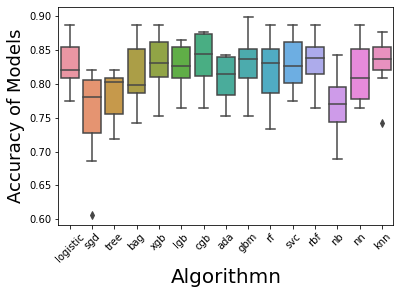

In [ ]:
# boxplot algorithm comparison
# fig = plt.figure(figsize=(15,6))
# fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
# ax = fig.add_subplot(111)
ax = sns.boxplot(x=names, y=scores)
# ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [ ]:
ensemble = VotingClassifier(
        methods,
        # voting='soft', 
#         weights=[1,1,1,1,2,2,1,1],
#         flatten_transform=True,
)

clf = Pipeline([
#          ('transformer', transformer),
     ('ensemble', ensemble),
])

clf.fit(clean_features.iloc[:train_df.shape[0],:], target)

Pipeline(memory=None,
         steps=[('ensemble',
                 VotingClassifier(estimators=[('logistic',
                                               LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                                  l1_ratio=None,
                                                                  max_iter=100,
                                                                  multi_class='auto',
                                                                  n_jobs=None,
                                                                  penalty='l2',
                                                                  random_st

In [ ]:
# # load JS visualization code to notebook
# shap.initjs()

# # train XGBoost model
# model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(clean_features.iloc[:train_df.shape[0],:], label=target), 100)

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(clean_features.iloc[:train_df.shape[0],:])

# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], clean_features.iloc[0,:])

In [ ]:
model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(clean_features.iloc[:train_df.shape[0],:], label=target), 100)

In [ ]:
submission['Survived'] = pd.DataFrame(clf.predict(clean_features.iloc[train_df.shape[0]:,:]))

In [ ]:
print(submission.dtypes)

PassengerId    int64
Survived       int64
dtype: object


In [ ]:
submission.to_csv("titanic_submission.csv", index=False)